In [95]:
import os
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt

### Elia Data Download

In [96]:
url = "https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods001/exports/csv?lang=en&timezone=Europe%2FBrussels&use_labels=true&delimiter=%3B"


# Read data from URL
data_raw = pd.read_csv(url, delimiter = ';')

data = data_raw.dropna()

In [97]:
# remove null entries due to data loading before full day has elapsed
data = data_raw.dropna()

# standardise to utc due to daylight saving. set date as index. remove excess columns
data['DateTime'] = pd.to_datetime(data['DateTime'], utc=True)
data.set_index('DateTime', inplace=True)
data.drop('Resolution code', axis=1, inplace=True)
data = data.sort_index()

C:\Users\Luke\AppData\Local\Temp\ipykernel_12860\3894841648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DateTime'] = pd.to_datetime(data['DateTime'], utc=True)
C:\Users\Luke\AppData\Local\Temp\ipykernel_12860\3894841648.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Resolution code', axis=1, inplace=True)


In [10]:
# experimentation around using diffs instead of raw values WIP

data_log_diff = data['Total Load'].sort_index().apply(np.log).diff().dropna()
print((data_log_diff.cumsum().apply(np.exp)+data.sort_index().iloc[0][0]).head(5))
# print(data.sort_index().values[0:5])
print(data.sort_index().head(5))

DateTime
2014-12-31 23:15:00+00:00    10143.181036
2014-12-31 23:30:00+00:00    10143.171333
2014-12-31 23:45:00+00:00    10143.158408
2015-01-01 00:00:00+00:00    10143.151824
2015-01-01 00:15:00+00:00    10143.134148
Name: Total Load, dtype: float64
                           Total Load
DateTime                             
2014-12-31 23:00:00+00:00    10142.19
2014-12-31 23:15:00+00:00    10051.28
2014-12-31 23:30:00+00:00     9952.87
2014-12-31 23:45:00+00:00     9821.78
2015-01-01 00:00:00+00:00     9755.00


### Weather Data

We get data from the 3 of the most populated cities in Belgium that are also geographically spread in all directions

In [98]:
from wx_data_openmeteo import get_openmeteo_geocoding_data, get_openmeteo_hist_api_request, get_openmeteo_api_response


start_date = data.index.min().strftime('%Y-%m-%d') # first date in load data
end_date = data.index.max().strftime('%Y-%m-%d') # last date in load data
freq = 'hourly'
wx_params = ['temperature_2m', 'precipitation', 'apparent_temperature']

def get_wx_df(city):
    '''Get weather dataframe for a city with renamed columns'''
    geocoding_data = get_openmeteo_geocoding_data(city)
    latitude = geocoding_data['results'][0]['latitude']
    longitude = geocoding_data['results'][0]['longitude']

    api_request = get_openmeteo_hist_api_request(latitude, longitude, start_date, end_date, freq, wx_params)
    df_wx = get_openmeteo_api_response(api_request, freq, wx_params)

    # rename columns except for datetime_utc column
    columns_renamed = [df_wx.columns[0]] 
    for column in df_wx.columns[1:]:
        new_column = column + '_' + city
        columns_renamed.append(new_column)

    df_wx.columns = columns_renamed
    df_wx.set_index('datetime_utc', inplace=True)
    return df_wx

df_wx_antwerp = get_wx_df('Antwerp')
df_wx_ghent = get_wx_df('Ghent')
df_wx_charleroi = get_wx_df('Charleroi')

In [99]:
df_wx_merged = df_wx_antwerp.merge(df_wx_ghent, 
                how = 'left', 
                left_index = True,
                right_index = True)

df_wx_merged = df_wx_merged.merge(df_wx_charleroi, 
                how = 'left', 
                left_index = True,
                right_index = True)

In [13]:
df_wx_merged.head(5)

,temperature_2m_Antwerp,precipitation_Antwerp,apparent_temperature_Antwerp,temperature_2m_Ghent,precipitation_Ghent,apparent_temperature_Ghent,temperature_2m_Charleroi,precipitation_Charleroi,apparent_temperature_Charleroi
datetime_utc,,,,,,,,,
2014-12-31 00:00:00+00:00,2.8,0.0,-0.5,2.8,0.0,-0.4,1.0,0.0,-2.6
2014-12-31 01:00:00+00:00,2.6,0.0,-0.7,2.3,0.0,-1.0,0.6,0.0,-2.9
2014-12-31 02:00:00+00:00,2.8,0.0,-0.6,2.4,0.0,-1.0,0.7,0.0,-2.9
2014-12-31 03:00:00+00:00,2.7,0.0,-0.5,2.3,0.0,-1.1,0.7,0.0,-2.7
2014-12-31 04:00:00+00:00,2.4,0.0,-0.7,2.0,0.0,-1.2,0.4,0.0,-2.9


### Visualising and preparing the Dataset

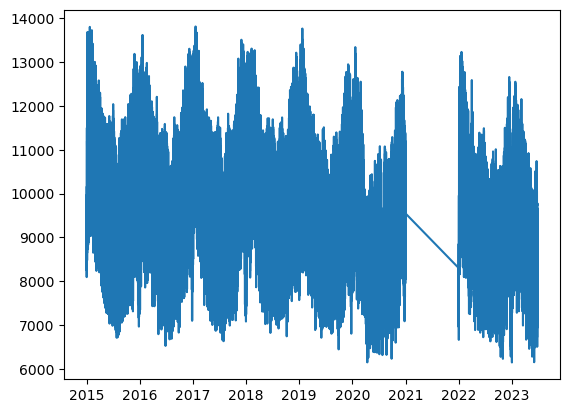

In [14]:
plt.figure()
plt.plot(data.index, data['Total Load'])
plt.show()

# Dates

Example:  If today is the 27th, and we want to predict 3 days in advance (including the date of model run)

For training and test purposes, we want to run the model and predict on the 24th the expected load on the 24th, 25th and 26th (since we have full data available when testing it on the 27th.

That is, the training data can be till the 23rd (four days back)

In [137]:
from datetime import date

today = date.today()
two_days_back = (today - datetime.timedelta(days=2)).strftime("%Y-%m-%d")
three_days_back = (today - datetime.timedelta(days=3)).strftime("%Y-%m-%d")
four_days_back = (today - datetime.timedelta(days=4)).strftime("%Y-%m-%d")

print('Today is {}'.format(today))
print('Two days back is {}'.format(two_days_back))
print('Three days back is {}'.format(three_days_back))
print('Four days back is {}'.format(four_days_back))


start_date = '2015-01-01'

df = data[start_date:today][0:-1] # remove last entry as that is today's date at 00:00:00

df.tail(2) # last 2 records in dataframe

Today is 2023-06-27
Two days back is 2023-06-25
Three days back is 2023-06-24
Four days back is 2023-06-23


C:\Users\Luke\AppData\Local\Temp\ipykernel_12860\1813670321.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df = data[start_date:today][0:-1] # remove last entry as that is today's date at 00:00:00


,Total Load
DateTime,
2023-06-26 23:30:00+00:00,7541.66
2023-06-26 23:45:00+00:00,7433.80


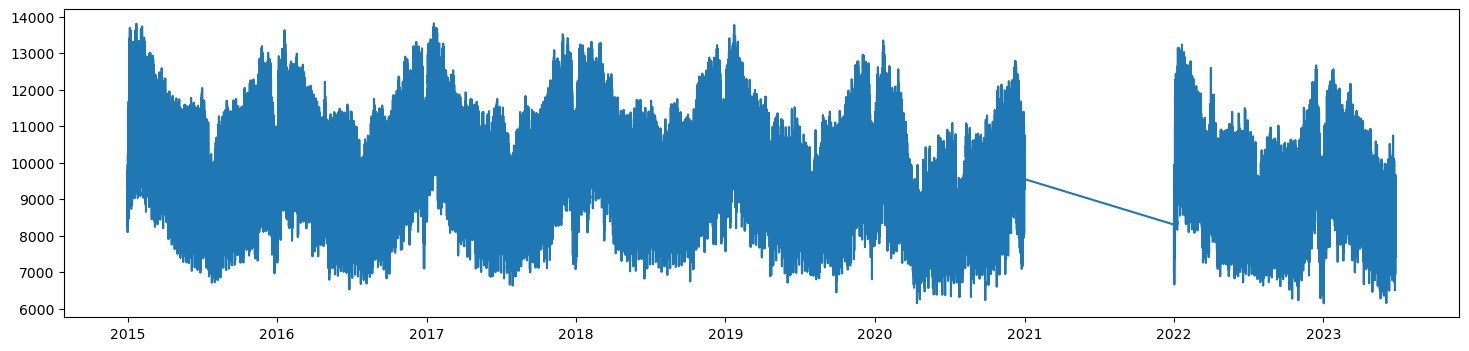

In [34]:
plt.figure(figsize = (18,4))
plt.plot(df.index, df['Total Load'])

### Create Calendar Features

#### Public Holidays

In [109]:
country_code = 'BE'
be_holidays = holidays.country_holidays(country_code)

In [110]:
df_hols = df[df.index.map(lambda x: x in be_holidays)]
df['is_holiday'] = np.where(df.index.isin(df_hols.index), 1, 0)
df.head(5)

,Total Load,is_holiday
DateTime,,
2015-01-01 00:00:00+00:00,9755.00,1
2015-01-01 00:15:00+00:00,9575.73,1
2015-01-01 00:30:00+00:00,9494.09,1
2015-01-01 00:45:00+00:00,9382.50,1
2015-01-01 01:00:00+00:00,9349.16,1


#### Date time features

In [111]:
def featurize_datetime_index(df, daytime=True):
    df = df.copy()
    
    df["minute"] = df.index.minute
    df["hour"] = df.index.hour
    df["weekday"] = df.index.dayofweek
    df["weekday_name"] = df.index.strftime("%A")
    df["month"] = df.index.month
    df["month_name"] = df.index.strftime("%B")
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["week_of_year"] = df.index.weekofyear
    df["day_of_year"] = df.index.dayofyear

    if daytime:
        # Add column with category for time of day:
        # midnight, early_morning, late_morning, afternoon, evening, night
        def time_of_day(hour):
            if hour >= 0 and hour < 6:
                return "midnight"
            elif hour >= 6 and hour < 9:
                return "early_morning"
            elif hour >= 9 and hour < 12:
                return "late_morning"
            elif hour >= 12 and hour < 15:
                return "afternoon"
            elif hour >= 15 and hour < 18:
                return "evening"
            else:
                return "night"

        df["time_of_day"] = (df["hour"].apply(time_of_day)).astype("category")

    df["weekday_name"] = df["weekday_name"].astype("category")
    df["month_name"] = df["month_name"].astype("category")

    return df

In [112]:
df_features = featurize_datetime_index(df.copy())

C:\Users\Luke\AppData\Local\Temp\ipykernel_12860\447565746.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week_of_year"] = df.index.weekofyear


In [113]:
# resample weather df to match that of the elec load
df_wx_merged = df_wx_merged.resample('15T').mean().ffill()

In [115]:
# join features together in 1 dataframe
df_features_merged = df_features.merge(df_wx_merged, 
                how = 'left', 
                left_index = True,
                right_index = True)

df_features_merged['week_of_year'] = df_features_merged.week_of_year.astype(float)

df_features_merged.head(5)

,Total Load,is_holiday,minute,hour,weekday,weekday_name,month,month_name,quarter,year,...,time_of_day,temperature_2m_Antwerp,precipitation_Antwerp,apparent_temperature_Antwerp,temperature_2m_Ghent,precipitation_Ghent,apparent_temperature_Ghent,temperature_2m_Charleroi,precipitation_Charleroi,apparent_temperature_Charleroi
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,9755.00,1,0,0,3,Thursday,1,January,1,2015,...,midnight,1.0,0.0,-3.1,1.1,0.0,-3.1,-0.4,0.0,-4.0
2015-01-01 00:15:00+00:00,9575.73,1,15,0,3,Thursday,1,January,1,2015,...,midnight,1.0,0.0,-3.1,1.1,0.0,-3.1,-0.4,0.0,-4.0
2015-01-01 00:30:00+00:00,9494.09,1,30,0,3,Thursday,1,January,1,2015,...,midnight,1.0,0.0,-3.1,1.1,0.0,-3.1,-0.4,0.0,-4.0
2015-01-01 00:45:00+00:00,9382.50,1,45,0,3,Thursday,1,January,1,2015,...,midnight,1.0,0.0,-3.1,1.1,0.0,-3.1,-0.4,0.0,-4.0
2015-01-01 01:00:00+00:00,9349.16,1,0,1,3,Thursday,1,January,1,2015,...,midnight,0.8,0.0,-3.5,0.7,0.0,-3.6,-0.7,0.0,-4.4


### Create Lagged Features

In [188]:
#df_features_merged['TotalLoadMaxLagged24h'] = df_features_merged['Total Load'].sort_index().rolling(24*4).max()
#df_features_merged['TotalLoadMinLagged24h'] = df_features_merged['Total Load'].sort_index().rolling(24*4).min()
#df_features_merged['TotalLoadMaxLagged36h'] = df_features_merged['Total Load'].sort_index().rolling(36*4).max()
#df_features_merged['TotalLoadMinLagged36h'] = df_features_merged['Total Load'].sort_index().rolling(36*4).min()
#df_features_merged['TotalLoadMaxLagged48h'] = df_features_merged['Total Load'].sort_index().rolling(48*4).max()
#df_features_merged['TotalLoadMinLagged48h'] = df_features_merged['Total Load'].sort_index().rolling(48*4).min()
#df_features_merged['TotalLoadMeanLagged48h'] = df_features_merged['Total Load'].sort_index().rolling(48*4).mean()
df_features_merged['TotalLoadMaxLagged72h'] = df_features_merged['Total Load'].sort_index().rolling(72*4).max()
df_features_merged['TotalLoadMinLagged72h'] = df_features_merged['Total Load'].sort_index().rolling(72*4).min()
df_features_merged['TotalLoadMeanLagged72h'] = df_features_merged['Total Load'].sort_index().rolling(72*4).mean()
df_features_merged['TotalLoadMaxLagged96h'] = df_features_merged['Total Load'].sort_index().rolling(96*4).max()
df_features_merged['TotalLoadMinLagged96h'] = df_features_merged['Total Load'].sort_index().rolling(96*4).min()
df_features_merged['TotalLoadMeanLagged96h'] = df_features_merged['Total Load'].sort_index().rolling(96*4).mean()
df_features_merged['TotalLoadMinTrend96to72'] =  (df_features_merged['TotalLoadMinLagged96h'] - df_features_merged['TotalLoadMinLagged72h'])/df_features_merged['TotalLoadMinLagged96h']
df_features_merged['TotalLoadMaxTrend96to72'] =  (df_features_merged['TotalLoadMaxLagged96h'] - df_features_merged['TotalLoadMaxLagged72h'])/df_features_merged['TotalLoadMaxLagged96h']

In [189]:
# drop records with null data
df_features_merged.dropna()

,Total Load,is_holiday,minute,hour,weekday,weekday_name,month,month_name,quarter,year,...,TotalLoadMaxLagged84h,TotalLoadMinLagged84h,TotalLoadMeanLagged84h,TotalLoadMinTrend84to72,TotalLoadMaxTrend84to72,TotalLoadMaxLagged96h,TotalLoadMinLagged96h,TotalLoadMeanLagged96h,TotalLoadMinTrend96to72,TotalLoadMaxTrend96to72
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-04 23:45:00+00:00,9889.00,0,45,23,6,Sunday,1,January,1,2015,...,11676.63,8243.51,9946.586696,0.0,0.000000,11676.63,8092.76,9789.676146,-0.018628,0.000000
2015-01-05 00:00:00+00:00,9844.29,0,0,0,0,Monday,1,January,1,2015,...,11676.63,8243.51,9948.748333,0.0,0.000000,11676.63,8092.76,9789.908672,-0.018628,0.000000
2015-01-05 00:15:00+00:00,9736.66,0,15,0,0,Monday,1,January,1,2015,...,11676.63,8243.51,9950.713006,0.0,0.000000,11676.63,8092.76,9790.327760,-0.018628,0.000000
2015-01-05 00:30:00+00:00,9627.48,0,30,0,0,Monday,1,January,1,2015,...,11676.63,8243.51,9952.301875,0.0,0.000000,11676.63,8092.76,9790.675130,-0.018628,0.000000
2015-01-05 00:45:00+00:00,9455.24,0,45,0,0,Monday,1,January,1,2015,...,11676.63,8243.51,9953.467827,0.0,0.000000,11676.63,8092.76,9790.864557,-0.018628,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26 22:45:00+00:00,7642.92,0,45,22,0,Monday,6,June,2,2023,...,9776.74,6502.53,8220.400685,0.0,0.011645,10049.62,6502.53,8257.953281,0.000000,0.038482
2023-06-26 23:00:00+00:00,7628.75,0,0,23,0,Monday,6,June,2,2023,...,9776.74,6502.53,8214.041190,0.0,0.011645,10049.62,6502.53,8258.125833,0.000000,0.038482
2023-06-26 23:15:00+00:00,7601.50,0,15,23,0,Monday,6,June,2,2023,...,9673.43,6502.53,8207.567262,0.0,0.001090,10049.62,6502.53,8258.186406,0.000000,0.038482


In [190]:
df_features_merged.sample(5)

,Total Load,is_holiday,minute,hour,weekday,weekday_name,month,month_name,quarter,year,...,TotalLoadMaxLagged84h,TotalLoadMinLagged84h,TotalLoadMeanLagged84h,TotalLoadMinTrend84to72,TotalLoadMaxTrend84to72,TotalLoadMaxLagged96h,TotalLoadMinLagged96h,TotalLoadMeanLagged96h,TotalLoadMinTrend96to72,TotalLoadMaxTrend96to72
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-09-25 18:00:00+00:00,8968.15,0,0,18,6,Sunday,9,September,3,2022,...,10245.99,6801.57,8697.999881,0.0,0.0,10245.99,6801.57,8674.788620,0.000000,0.000000
2023-04-07 07:00:00+00:00,10761.22,0,0,7,4,Friday,4,April,2,2023,...,11054.17,7771.41,9594.219643,0.0,0.0,11207.74,7771.41,9689.874974,0.000000,0.013702
2019-12-03 13:15:00+00:00,11590.65,0,15,13,1,Tuesday,12,December,4,2019,...,12949.94,7887.89,10365.427321,0.0,0.0,12949.94,7887.89,10407.398021,0.000000,0.000000
2017-09-21 21:45:00+00:00,9057.83,0,45,21,3,Thursday,9,September,3,2017,...,11389.70,7803.08,10029.147381,0.0,0.0,11389.70,7307.95,9908.257214,-0.067752,0.000000
2017-04-29 22:15:00+00:00,8738.75,0,15,22,5,Saturday,4,April,2,2017,...,11587.71,8466.84,10102.769821,0.0,0.0,11587.71,8466.84,10103.174271,0.000000,0.000000


### Split into train and test sets

In [191]:
train_data = df_features_merged.sort_index()[start_date:four_days_back]
test_data = df_features_merged.sort_index()[three_days_back:today]

#test_data.head(5)

train_data = pd.get_dummies(data=train_data, columns = ['time_of_day'])
test_data = pd.get_dummies(data=test_data, columns = ['time_of_day'])

C:\Users\Luke\AppData\Local\Temp\ipykernel_12860\685846674.py:2: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  test_data = df_features_merged.sort_index()[three_days_back:today]


In [174]:
train_data.columns

Index(['Total Load', 'is_holiday', 'minute', 'hour', 'weekday', 'weekday_name',
       'month', 'month_name', 'quarter', 'year', 'week_of_year', 'day_of_year',
       'temperature_2m_Antwerp', 'precipitation_Antwerp',
       'apparent_temperature_Antwerp', 'temperature_2m_Ghent',
       'precipitation_Ghent', 'apparent_temperature_Ghent',
       'temperature_2m_Charleroi', 'precipitation_Charleroi',
       'apparent_temperature_Charleroi', 'TotalLoadMaxLagged72h',
       'TotalLoadMinLagged72h', 'TotalLoadMeanLagged72h',
       'TotalLoadMaxLagged84h', 'TotalLoadMinLagged84h',
       'TotalLoadMeanLagged84h', 'TotalLoadMinTrend84to72',
       'TotalLoadMaxTrend84to72', 'time_of_day_afternoon',
       'time_of_day_early_morning', 'time_of_day_evening',
       'time_of_day_late_morning', 'time_of_day_midnight',
       'time_of_day_night'],
      dtype='object')

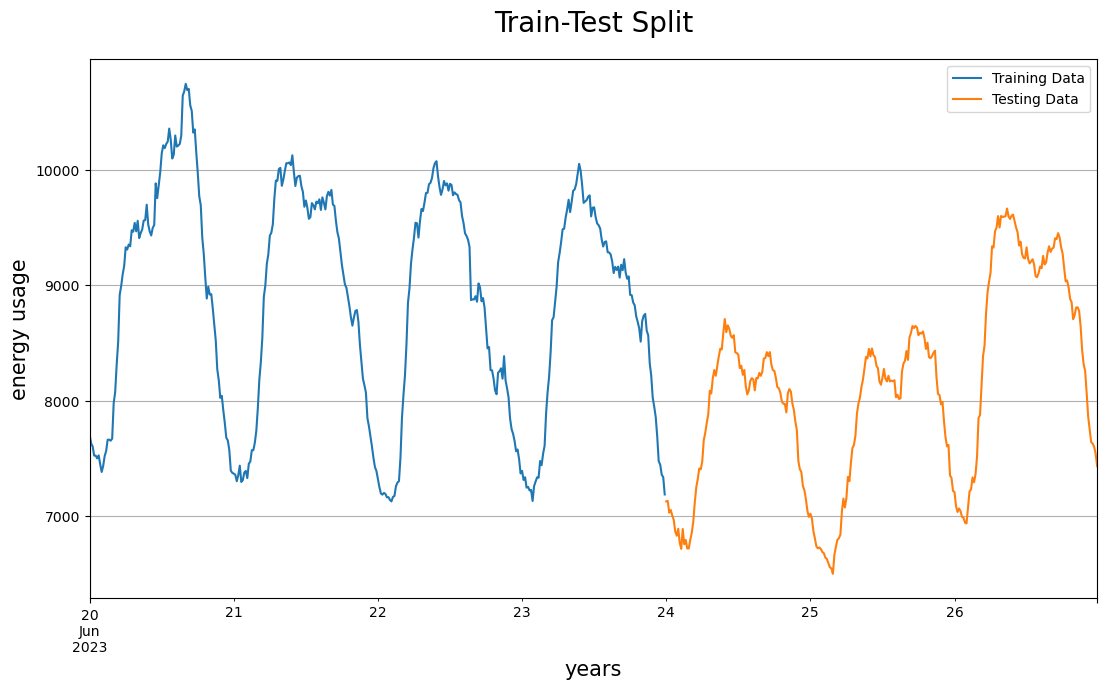

In [175]:
fig, ax = plt.subplots(figsize = (13, 7))
train_data['Total Load'][((today - datetime.timedelta(days=7)).strftime("%Y-%m-%d")):].plot(ax = ax, label = 'Training Data');
test_data['Total Load'].plot(ax = ax, label = 'Testing Data');
ax.grid()
plt.xlabel('years', fontsize = 15)
plt.ylabel('energy usage', fontsize = 15)
plt.title('Train-Test Split', fontsize = 20, pad = 20);
plt.legend()
plt.show()

## Machine Learning Model

In [192]:
features = df_features_merged.columns.values
features = features.tolist()
features.remove('Total Load')
features.remove('time_of_day')
features.remove('weekday_name')
features.remove('month_name')

print(features)

['is_holiday', 'minute', 'hour', 'weekday', 'month', 'quarter', 'year', 'week_of_year', 'day_of_year', 'temperature_2m_Antwerp', 'precipitation_Antwerp', 'apparent_temperature_Antwerp', 'temperature_2m_Ghent', 'precipitation_Ghent', 'apparent_temperature_Ghent', 'temperature_2m_Charleroi', 'precipitation_Charleroi', 'apparent_temperature_Charleroi', 'TotalLoadMaxLagged72h', 'TotalLoadMinLagged72h', 'TotalLoadMeanLagged72h', 'TotalLoadMaxLagged84h', 'TotalLoadMinLagged84h', 'TotalLoadMeanLagged84h', 'TotalLoadMinTrend84to72', 'TotalLoadMaxTrend84to72', 'TotalLoadMaxLagged96h', 'TotalLoadMinLagged96h', 'TotalLoadMeanLagged96h', 'TotalLoadMinTrend96to72', 'TotalLoadMaxTrend96to72']


In [193]:
target = 'Total Load'
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [179]:
from xgboost import XGBRegressor
#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import TimeSeriesSplit

In [228]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators = 700, 
                             max_depth = 6, learning_rate = 0.01, early_stopping_rounds = 50, 
                             subsample = 0.7, colsample_bytree = 0.8)

In [229]:
xgb_regressor.fit(X_train, y_train,
                    eval_set = [(X_train, y_train), 
                    (X_test, y_test)], verbose = 25)

[0]	validation_0-rmse:9707.42008	validation_1-rmse:8058.29314
[25]	validation_0-rmse:7561.67442	validation_1-rmse:6212.84460
[50]	validation_0-rmse:5892.93690	validation_1-rmse:4804.96668
[75]	validation_0-rmse:4595.36423	validation_1-rmse:3724.27551
[100]	validation_0-rmse:3586.66604	validation_1-rmse:2888.79020
[125]	validation_0-rmse:2801.62306	validation_1-rmse:2243.56431
[150]	validation_0-rmse:2194.32366	validation_1-rmse:1743.13393
[175]	validation_0-rmse:1724.30410	validation_1-rmse:1360.17394
[200]	validation_0-rmse:1360.65581	validation_1-rmse:1065.93450
[225]	validation_0-rmse:1081.00916	validation_1-rmse:835.10945
[250]	validation_0-rmse:866.54120	validation_1-rmse:662.78600
[275]	validation_0-rmse:703.71536	validation_1-rmse:537.62583
[300]	validation_0-rmse:581.63316	validation_1-rmse:444.76435
[325]	validation_0-rmse:490.76003	validation_1-rmse:376.32506
[350]	validation_0-rmse:424.61684	validation_1-rmse:328.35643
[375]	validation_0-rmse:377.13543	validation_1-rmse:293.

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

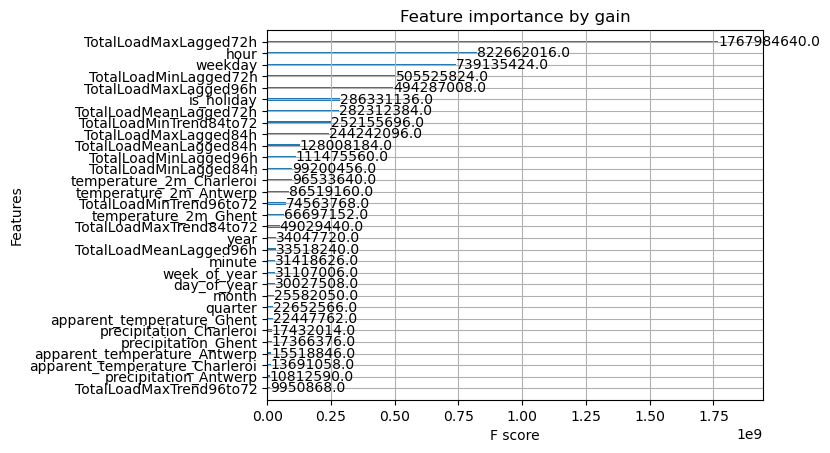

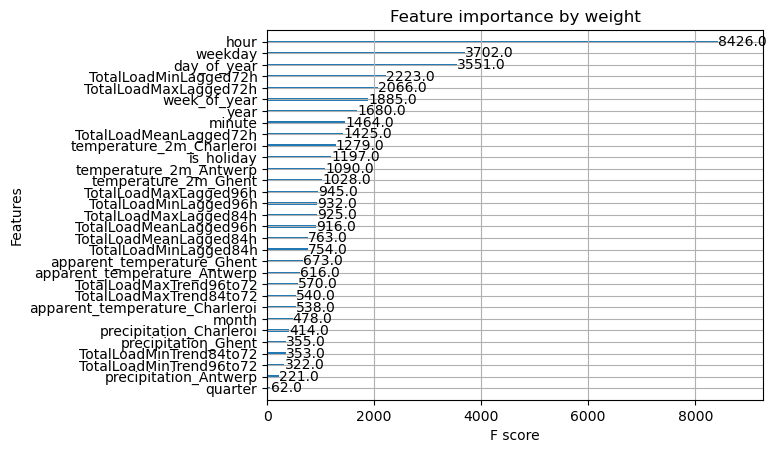

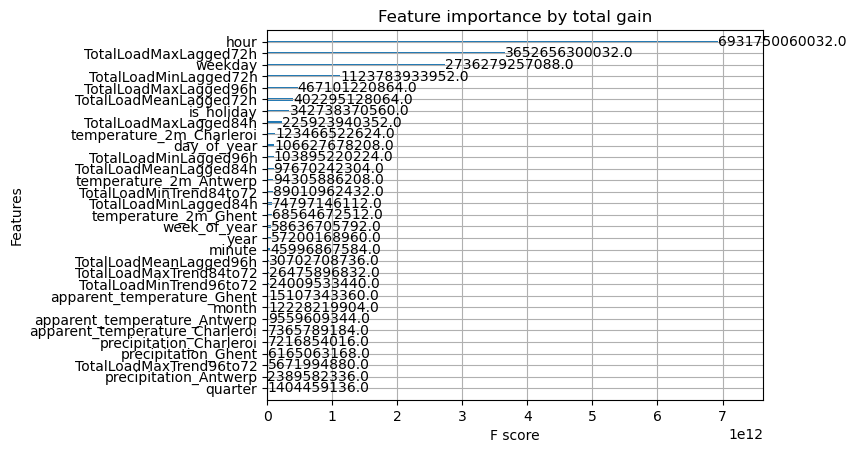

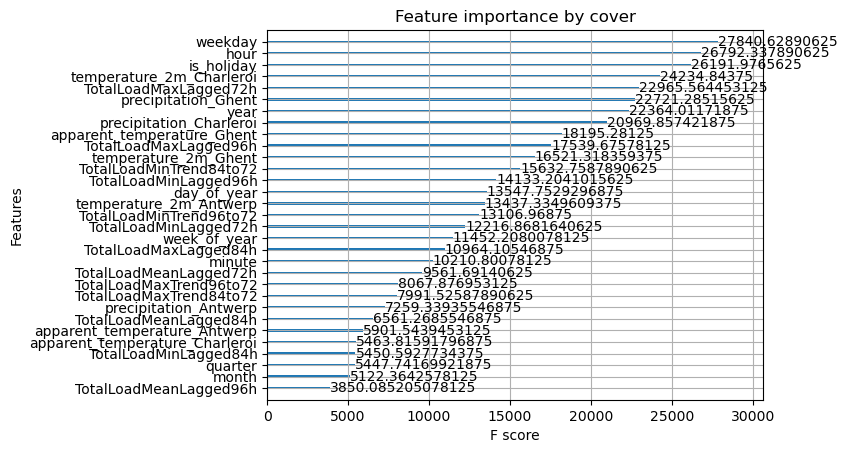

In [230]:
from xgboost import plot_importance as xgb_plot_importance

xgb_plot_importance(xgb_regressor, importance_type = 'gain')
plt.title('Feature importance by gain')

xgb_plot_importance(xgb_regressor, importance_type = 'weight')
plt.title('Feature importance by weight')

xgb_plot_importance(xgb_regressor, importance_type = 'total_gain')
plt.title('Feature importance by total gain')

xgb_plot_importance(xgb_regressor, importance_type = 'cover')
plt.title('Feature importance by cover')

plt.show()



## Predicting on the Test Set

In [231]:
test_data['prediction'] = xgb_regressor.predict(X_test)

In [232]:
results = df_features_merged.merge(test_data['prediction'], 
                how = 'left', 
                left_index = True,
                right_index = True)

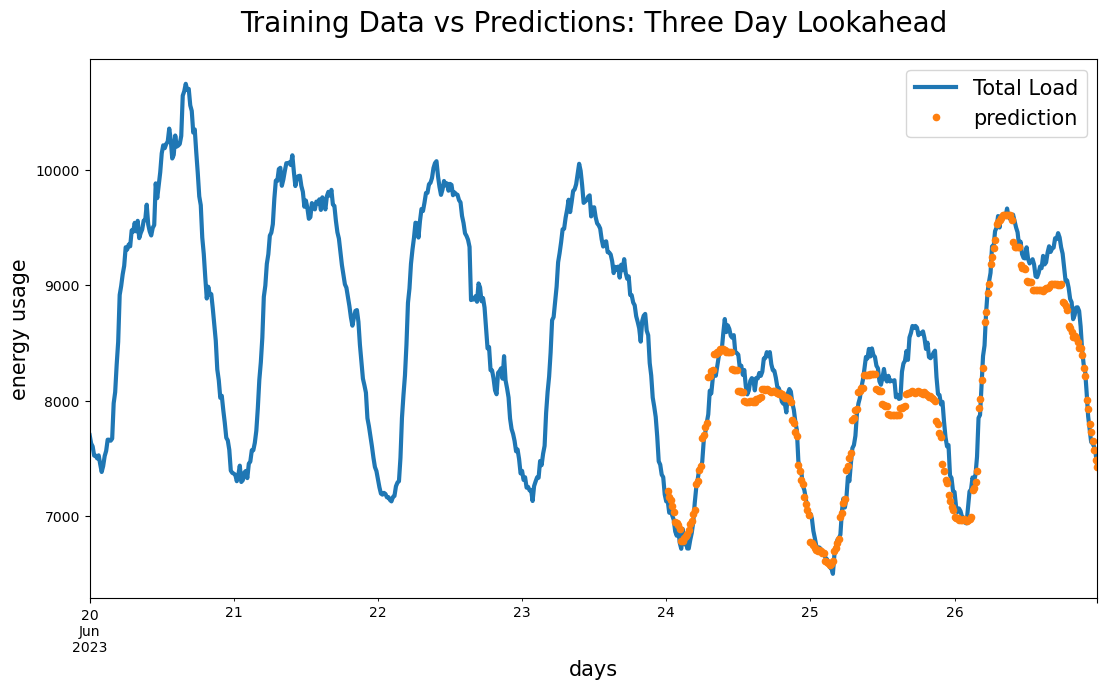

In [233]:
plt.figure(figsize = (13, 7))
ax = results[((today - datetime.timedelta(days=7)).strftime("%Y-%m-%d")):]['Total Load']\
            .plot(linewidth = 3);
results.loc[(results.index > three_days_back)]\
    ['prediction'].plot(style = '.', markersize = 9);
plt.legend()
plt.xlabel('days', fontsize = 15)
plt.ylabel('energy usage', fontsize = 15)
plt.title('Training Data vs Predictions: Three Day Lookahead', fontsize = 20, pad = 20);
plt.legend(fontsize = 15)
plt.show()

In [234]:
import numpy as np
temp = results[['Total Load', 'prediction']].copy()
temp['date'] = temp.index.strftime('%A, %b %d, %Y')
temp['error'] = np.abs(results['Total Load'] - results['prediction'])
temp['norm_error'] = temp['error']/temp['Total Load']

In [235]:
summation = temp[three_days_back:]['norm_error'].sum()
counts = temp[three_days_back:]['norm_error'].count()
avg_error = summation/counts*100.0

In [236]:
avg_error

2.024730109310668

## Modeling with LGBM

In [220]:
import lightgbm as lgb

params = {'boosting_type':'gbdt',
          'metric':'rmse',
          'n_jobs':8,
          'learning_rate':0.01,
          'num_leaves': 2**8,
          'max_depth':-1,
          'tree_learner':'serial',
          'colsample_bytree': 0.9,
          'subsample_freq':1,
          'subsample':0.5,
          'max_bin':255,
          'early_stopping_rounds':100,
          "verbosity": -1,
          "bagging_seed": 42,
          'drop_seed': 1333,
          'data_random_seed': 299,
         }

#run model
lgb_regressor = lgb.LGBMRegressor(**params, n_estimators = 700)
lgb_regressor.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse', verbose = 25)


C:\Users\Luke\Anaconda3\envs\ml\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[25]	training's rmse: 1110.9	valid_1's rmse: 1421.83
[50]	training's rmse: 900.723	valid_1's rmse: 1119.44
[75]	training's rmse: 734.284	valid_1's rmse: 882.917
[100]	training's rmse: 606.932	valid_1's rmse: 699.633
[125]	training's rmse: 509.612	valid_1's rmse: 556.435
[150]	training's rmse: 434.269	valid_1's rmse: 446.484
[175]	training's rmse: 378.29	valid_1's rmse: 366.092
[200]	training's rmse: 336.215	valid_1's rmse: 307.931
[225]	training's rmse: 301.767	valid_1's rmse: 266.552
[250]	training's rmse: 275.588	valid_1's rmse: 240.008
[275]	training's rmse: 255.318	valid_1's rmse: 224.826
[300]	training's rmse: 239.553	valid_1's rmse: 215.395
[325]	training's rmse: 226.712	valid_1's rmse: 212.001
[350]	training's rmse: 216.35	valid_1's rmse: 212.194
[375]	training's rmse: 207.907	valid_1's rmse: 214.428
[400]	training's rmse: 200.266	valid_1's rmse: 220.04
[425]	training's rmse: 193.6	valid_1's rmse: 223.857


LGBMRegressor(bagging_seed=42, colsample_bytree=0.9, data_random_seed=299,
              drop_seed=1333, early_stopping_rounds=100, learning_rate=0.01,
              max_bin=255, metric='rmse', n_estimators=700, n_jobs=8,
              num_leaves=256, subsample=0.5, subsample_freq=1,
              tree_learner='serial', verbosity=-1)

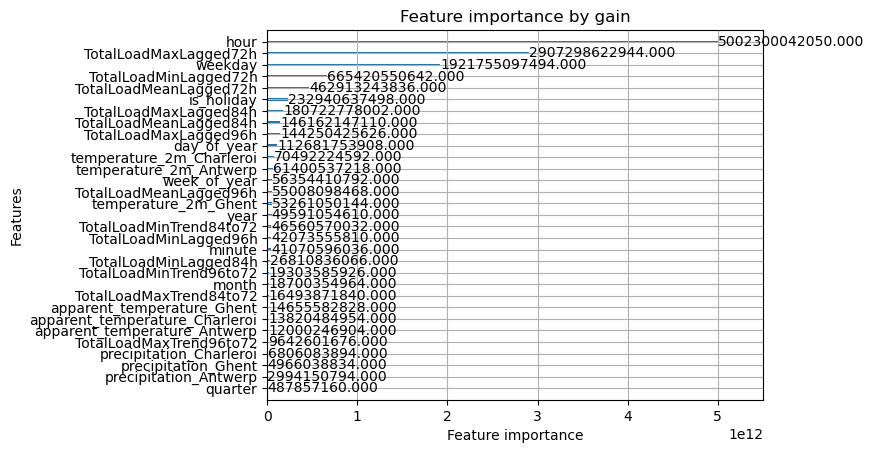

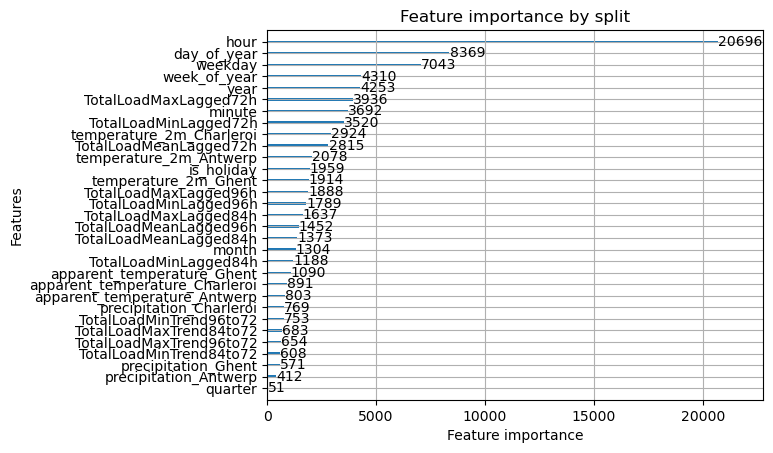

In [221]:
lgb.plot_importance(lgb_regressor, importance_type = 'gain')
plt.title('Feature importance by gain')

lgb.plot_importance(lgb_regressor, importance_type = 'split')
plt.title('Feature importance by split')

plt.show()

In [222]:
test_data['prediction'] = lgb_regressor.predict(X_test)

In [223]:
results = df_features_merged.merge(test_data['prediction'], 
                how = 'left', 
                left_index = True,
                right_index = True)

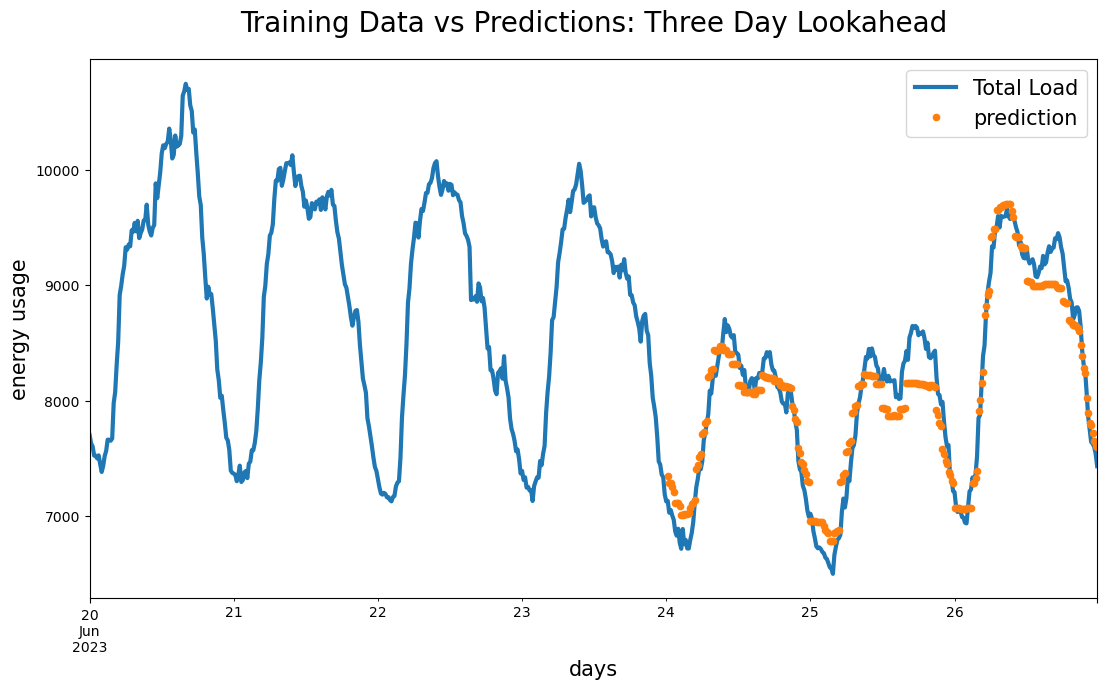

In [224]:
plt.figure(figsize = (13, 7))
ax = results[((today - datetime.timedelta(days=7)).strftime("%Y-%m-%d")):]['Total Load']\
            .plot(linewidth = 3);
results.loc[(results.index > three_days_back)]\
    ['prediction'].plot(style = '.', markersize = 9);
plt.legend()
plt.xlabel('days', fontsize = 15)
plt.ylabel('energy usage', fontsize = 15)
plt.title('Training Data vs Predictions: Three Day Lookahead', fontsize = 20, pad = 20);
plt.legend(fontsize = 15)
plt.show()

In [225]:
temp = results[['Total Load', 'prediction']].copy()
temp['date'] = temp.index.strftime('%A, %b %d, %Y')
temp['error'] = np.abs(results['Total Load'] - results['prediction'])
temp['norm_error'] = temp['error']/temp['Total Load']

In [226]:
summation = temp[three_days_back:]['norm_error'].sum()
counts = temp[three_days_back:]['norm_error'].count()
avg_error = summation/counts*100.0

In [227]:
avg_error

2.2065011082200634

## EDA Plots Done before Modeling

In [43]:
import seaborn as sns
def boxplot_correlation(df, feature_x, feature_y, order=None, palette=None):

    fig, ax = plt.subplots(figsize=(13, 7))
    sns.set_style("whitegrid")

    sns.boxplot(data=df, x=feature_x, y=feature_y, order=order, palette=palette)

    x_name = str(df[feature_x].name)
    y_name = str(df[feature_y].name)

    ax.grid()
    plt.xlabel(x_name, fontsize=15)
    plt.ylabel(y_name, fontsize=15)
    plt.title(
        f"Feature Correlation: {x_name.capitalize()} - {y_name.capitalize()}",
        fontsize=20,
        pad=20
    )

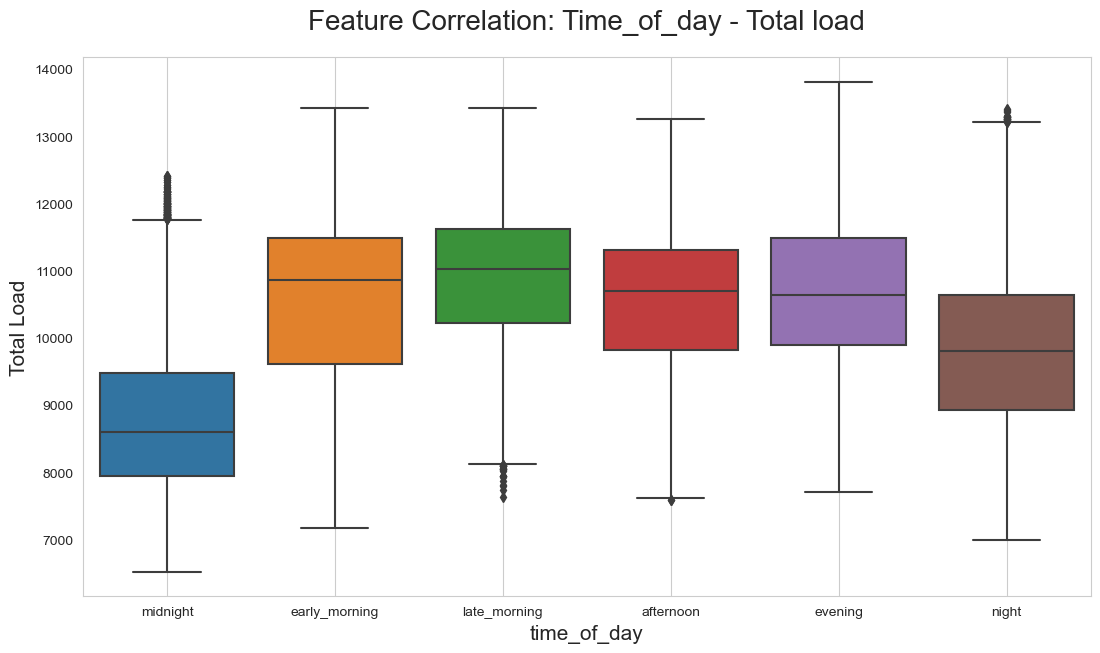

In [46]:
daytimes = ['midnight', 'early_morning', 'late_morning', 'afternoon', 'evening', 'night']
boxplot_correlation(df_features, 'time_of_day', 'Total Load', order = daytimes)

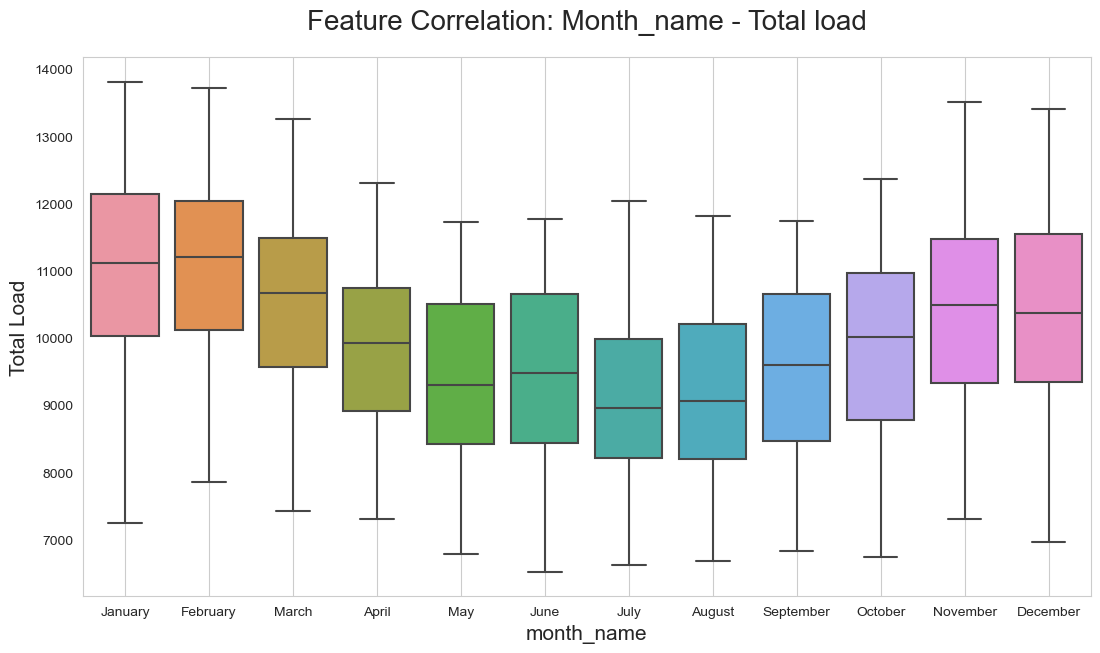

In [47]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                  'August', 'September', 'October', 'November', 'December']
boxplot_correlation(df_features, 'month_name', 'Total Load', order = months)

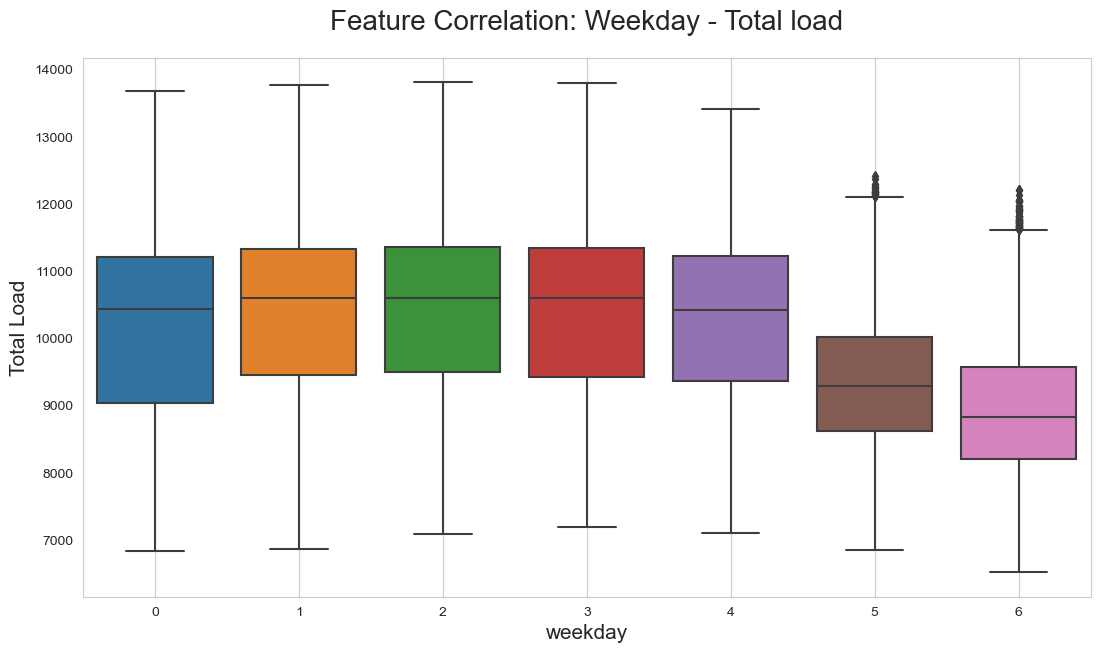

In [45]:
boxplot_correlation(df_features, 'weekday', 'Total Load')

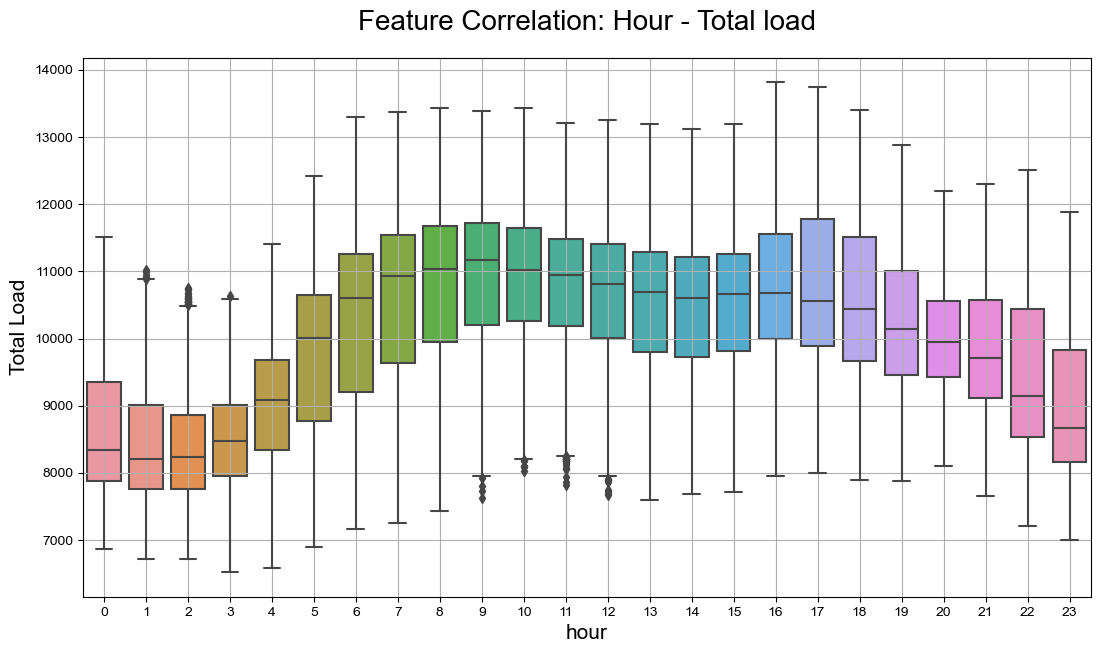

In [44]:
boxplot_correlation(df_features, 'hour', 'Total Load')